# Image Classification for Intel Landmarks Dataset

In this project, we will work with the Intel Image dataset, which includes images of various scenes such as buildings, forests, streets, and more. We will build a Convolutional Neural Network (CNN) using Keras to train and classify these images into multiple categories. This is a multi-class classification problem that leverages deep learning techniques for accurate scene recognition.

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


First, we will mount Google Drive in Google Colab to access the dataset directly from the drive. To do this, you need to upload the dataset to your Google Drive beforehand and then mount the drive in Colab.

In [2]:
# After executing the cell above, Drive files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive/Intel_Image_Classification/Data/Intel Image Dataset"

buildings  forest  glacier  mountain  sea  street


After mounting the drive, we will navigate to the folder where the dataset is stored to access it in our Colab notebook. In this case, we will list all the folders in the drive, and the 'Intel Image Dataset' folder contains the images we will be working with.

We will begin by importing the necessary libraries.

In [3]:
# Essential Libraries
import numpy as np
import pandas as pd
import random
import cv2
from os import listdir

# Visualization Libraries
import matplotlib.pyplot as plt
from matplotlib.image import imread

# Image Processing Libraries
from PIL import Image
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, array_to_img

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

# Deep Learning Libraries
from keras.models import Sequential
from keras.layers import (Conv2D, MaxPooling2D, Flatten, Dropout, Dense,
                          BatchNormalization, Activation, LeakyReLU)
from keras.optimizers import Adam


We will explore the directories to identify the folders containing the class images.

In [5]:
# Listing directory
!ls "/content/drive/My Drive/Intel_Image_Classification/Data/Intel Image Dataset"

buildings  forest  glacier  mountain  sea  street


Let's visualize a few sample images from the forest class that we will be working with. Additionally, we will examine the x and y dimensions of these images.

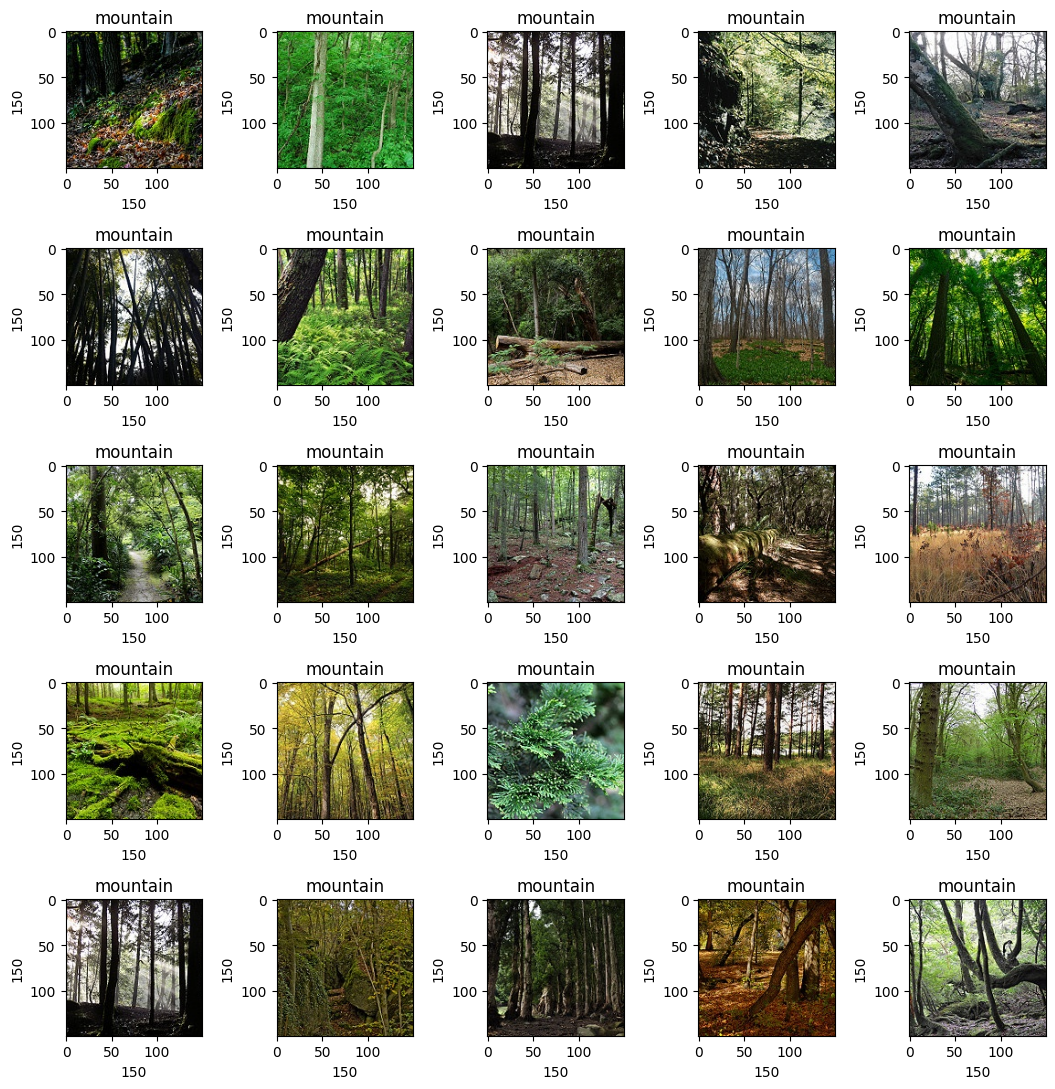

In [7]:
# Plotting 25 images to check dataset
plt.figure(figsize=(11,11))
path = "/content/drive/My Drive/Intel_Image_Classification/Data/Intel Image Dataset/forest"
for i in range(1,26):
    plt.subplot(5,5,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(listdir(path))))
    plt.imshow(rand_img)
    plt.title('mountain')
    plt.xlabel(rand_img.shape[1], fontsize = 10)
    plt.ylabel(rand_img.shape[0], fontsize = 10)

We will set the root directory for the dataset and retrieve the names of all the folders within it. Additionally, we will create two empty lists: one for storing the images and the other for the corresponding labels.

In [8]:
# Setting root directory path and creating empty list
dir = "/content/drive/My Drive/Intel_Image_Classification/Data/Intel Image Dataset"
root_dir = listdir(dir)
image_list, label_list = [], []

Next, we need to ensure all images have the same dimensions, as some may vary in size. To do this, we will read and resize each image, convert it into an array, and append the corresponding image and its label to the lists we created earlier.

In [9]:
# Reading and converting image to numpy array
for directory in root_dir:
  for files in listdir(f"{dir}/{directory}"):
    image_path = f"{dir}/{directory}/{files}"
    image = Image.open(image_path)
    image = image.resize((150,150)) # All images does not have same dimension
    image = img_to_array(image)
    image_list.append(image)
    label_list.append(directory)

We will check the number of images available in each class.

In [10]:
# Visualize the number of classes count
label_counts = pd.DataFrame(label_list).value_counts()
label_counts

,count
0,
glacier,553
mountain,525
sea,510
street,501
forest,474
buildings,447


We will store the number of classes, which will be used later in the model architecture.

In [11]:
# Checking count of classes
num_classes = len(label_counts)
num_classes

6

We will check the shape of the input data (x) to ensure it is compatible with the input layer of the model architecture.

In [12]:
# Checking x data shape
np.array(image_list).shape

(3010, 150, 150, 3)

We will verify that the number of labels in the y data matches the total number of images to ensure consistency.

In [13]:
# Checking y data shape
label_list = np.array(label_list)
label_list.shape

(3010,)

We will now split our dataset into training and testing sets using the train_test_split() function from sklearn.

In [14]:
# Splitting dataset into test and train
x_train, x_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.2, random_state = 10)

Next, we will normalize the images by dividing the pixel values by 255. Additionally, we will reshape the x_train and x_test data.

In [15]:
# Normalize and reshape data
x_train = np.array(x_train, dtype=np.float16) / 225.0
x_test = np.array(x_test, dtype=np.float16) / 225.0
x_train = x_train.reshape( -1, 150,150,3)
x_test = x_test.reshape( -1, 150,150,3)

Here, we will use the LabelBinarizer to one-hot encode our y data. We will also print the sequence of the class labels.

In [16]:
# Binarizing labels
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)
print(lb.classes_)

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


Now, we will split the training data into training and validation sets.

In [17]:
# Splitting the training data set into training and validation data sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)

Now, we will design the network architecture for the model. We will use different types of layers based on their specific functions:

* BatchNormalization: A technique to standardize the inputs to a layer for each mini-batch, helping to stabilize and accelerate the training of deep neural networks.
* LeakyReLU: A variation of the ReLU activation function that allows small negative values when the input is less than zero, addressing the "dying ReLU" problem.
* Conv2D: This layer creates a convolutional kernel that is convolved with the input layer, producing the output tensor.
* MaxPooling2D: A downsampling technique that extracts the maximum value over a window defined by the pool size, reducing the spatial dimensions.
* Flatten: This layer flattens the input, converting it into a 1D array to pass to the fully connected layers.
* Dense: A fully connected layer where the output is computed as the dot product of the input and the kernel.

In the final layer, we will use the Softmax activation function, as this is a multi-class classification problem.

In [18]:
# Creating model architecture
model = Sequential([
        Conv2D(16, kernel_size = (3,3), input_shape = (150,150,3)),
        BatchNormalization(),
        LeakyReLU(),

        Conv2D(32, kernel_size = (3,3)),
        BatchNormalization(),
        LeakyReLU(),
        MaxPooling2D(5,5),

        Conv2D(64, kernel_size = (3,3)),
        BatchNormalization(),
        LeakyReLU(),

        Conv2D(128, kernel_size = (3,3)),
        BatchNormalization(),
        LeakyReLU(),
        MaxPooling2D(5,5),

        Flatten(),

        Dense(64),
        Dropout(rate = 0.2),
        BatchNormalization(),
        LeakyReLU(),

        Dense(32),
        Dropout(rate = 0.2),
        BatchNormalization(),
        LeakyReLU(),

        Dense(16),
        Dropout(rate = 0.2),
        BatchNormalization(),
        LeakyReLU(1),

        Dense(6, activation = 'softmax')
        ])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 148, 148, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 148, 148, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 146, 146, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 146, 146, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 146, 146, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 29, 29, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 27, 27, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 27, 27, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 27, 27, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 25, 25, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 25, 25, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         204,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 64)                  │              

 Total params: 306,422 (1.17 MB)

 Trainable params: 305,718 (1.17 MB)

 Non-trainable params: 704 (2.75 KB)

To compile the model, we need to specify three parameters: loss, optimizer, and metrics. In this case, we will use categorical_crossentropy as the loss function, Adam as the optimizer, and accuracy as the metric.

In [19]:
# Compiling model
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0005),metrics=['accuracy'])

We will fit the model to the data and monitor the accuracy at each epoch to observe how the model is learning. The model will be trained for 70 epochs with a batch size of 128. You can experiment with increasing the number of epochs to potentially improve accuracy. During training, we can track the model's performance by viewing both the training and validation accuracy at each epoch.

In [33]:
# Training the model
epochs = 70
batch_size = 128
history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (x_val, y_val))

Epoch 1/70
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.9700 - loss: 0.1162 - val_accuracy: 0.6826 - val_loss: 1.0773
Epoch 2/70
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.9530 - loss: 0.1639 - val_accuracy: 0.7386 - val_loss: 0.9569
Epoch 3/70
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.9558 - loss: 0.1423 - val_accuracy: 0.7593 - val_loss: 0.8360
Epoch 4/70
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.9778 - loss: 0.0852 - val_accuracy: 0.7635 - val_loss: 0.8196
Epoch 5/70
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.9865 - loss: 0.0742 - val_accuracy: 0.7801 - val_loss: 0.7550
Epoch 6/70
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.9848 - loss: 0.0778 - val_accuracy: 0.7344 - val_loss: 0.9474
Epoch 7/70
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.9738 - loss: 0.0936 - val_accuracy: 0.7178 - val_loss: 1.0505
Epoch 8/70
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.9752 - loss: 0.0971 - val_accuracy: 0.

We will save the model using model.save() so that it can be used later for making predictions.

In [34]:
# Saving model
model.save("/content/drive/My Drive/intel_image.h5")

Next, we will plot the accuracy of the model based on the training history.

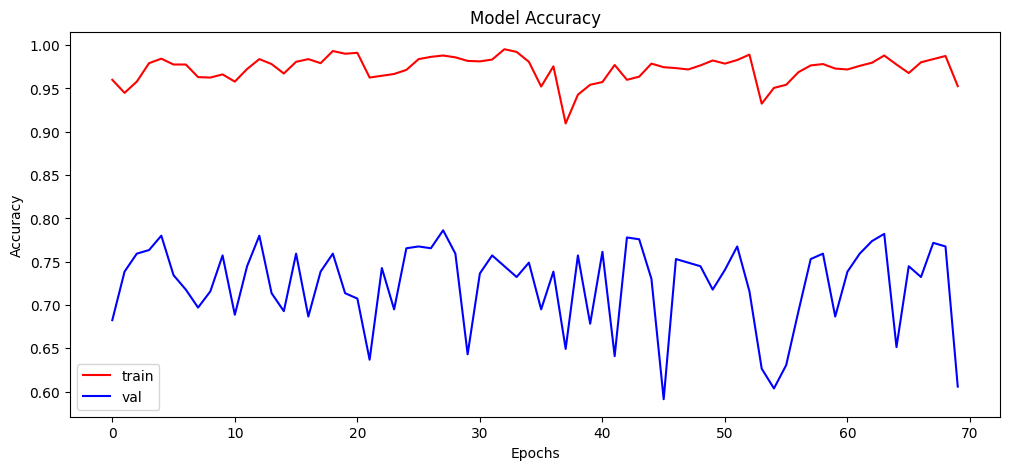

In [36]:
#Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

Next, we will plot the loss of the model based on the training history.



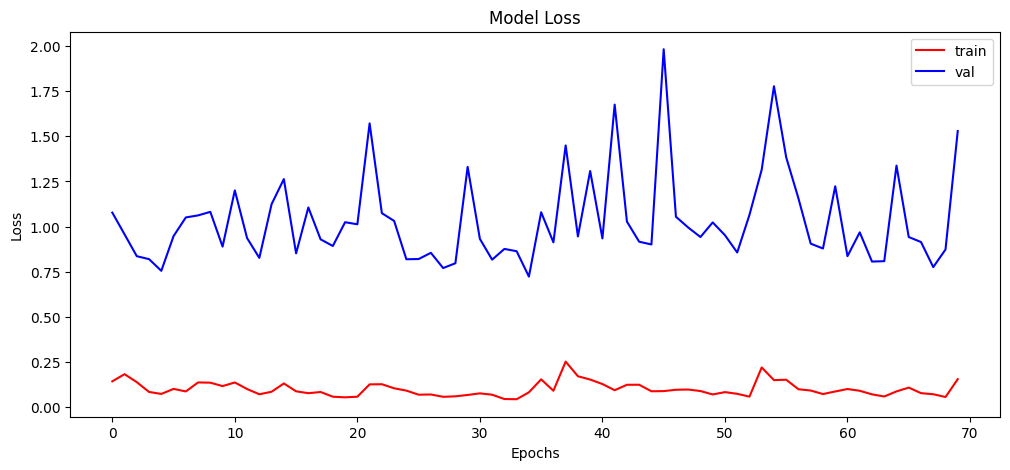

In [37]:
#Plot the loss history
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='b')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

We will evaluate the model to determine its accuracy on the test data.



In [38]:
# Calculating test accuracy
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6446 - loss: 1.4568
Test Accuracy: 64.28571343421936


We will generate predictions for the test data and store them in the variable y_pred.

In [39]:
# Storing model predictions
y_pred = model.predict(x_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


We will visualize an image that will be used for prediction in the upcoming steps.

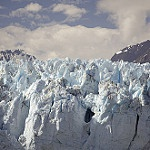

In [40]:
# Plotting image to compare
img = array_to_img(x_test[1])
img

Now, we will create a list of labels using the LabelBinarizer object. We will print this list and, finally, display the prediction along with the original label of the image we visualized earlier using argmax().

In [41]:
# Finding max value from predition list and comaparing original value vs predicted
labels = lb.classes_
print(labels)
print("Originally : ",labels[np.argmax(y_test[1])])
print("Predicted : ",labels[np.argmax(y_pred[1])])

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']
Originally :  glacier
Predicted :  glacier


## Conclusion:

In this project, we demonstrated how to create a CNN using various layers. Normalization is a crucial step when working with any dataset. We will use this model to predict the class of any image provided to it.

## Scope:

This project has a wide range of applications and can be used to classify various types of images, such as satellite images, drone images, and Google images, into different categories like sea, mountains, and more.